## Paper Figures

This is a notebook for reproducing paper figures. 

In [71]:
from vonmises import mol_utils
from rdkit import Chem
import pandas as pd 
import os
import seaborn as sns
import matplotlib.pyplot as plt
from vonmises.sqlalchemy_model import Molecule, create_session
from sqlalchemy import create_engine, MetaData, select, Table, func
import numpy as np
import scipy
import sqlitedict
import pickle
from typing import List
import math
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
import ot
from scipy.stats import entropy
from torch.distributions.von_mises import VonMises
import torch
from tqdm import tqdm
from rdkit.Chem.Lipinski import RotatableBondSmarts
import matplotlib

In [72]:
WORKING_DIR = "results"

Butane torsion joint histogram plot, using 560 conformations of butane from PT-HMC. 

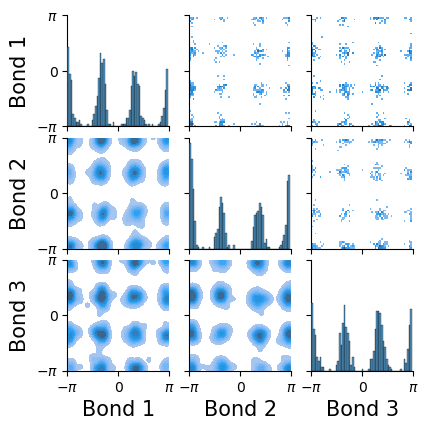

In [73]:
mol = Chem.Mol(open("data/visualization-demo-butane-pt-new-20221124.bin", "rb").read())
df = mol_utils.compute_rotatable_bond_torsions(mol)
df.columns = ["Bond 1", "Bond 2", "Bond 3"]
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 10})
matplotlib.rcParams.update({'ytick.labelsize': 10})
g = sns.PairGrid(df)
g.set(ylim=(-math.pi, math.pi), xlim=(-math.pi, math.pi), 
      xticks=[-math.pi, 0., math.pi], 
      xticklabels=['$-\pi$', 0, '$\pi$'],
      yticks=[-math.pi, 0., math.pi], 
      yticklabels=['$-\pi$', 0, '$\pi$'])
g.map_upper(sns.histplot, bins=list(np.arange(-math.pi, math.pi, 0.1)))
g.map_lower(sns.kdeplot, fill=True, bw_adjust=0.25)
g.map_diag(sns.histplot, bins=list(np.arange(-math.pi, math.pi, 0.1)))
g.fig.set_size_inches(4.,4.)
g.fig.savefig("butane_pt_hist.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Timing analysis. 

Run ```generate_time_analysis.py```. 

Optional: to reproduce the generated conformations contained in "conformation.dists-nmrshiftdb-timing-cpu" and "conformation.dists-nmrshiftdb-timing-gpu", run ```OMP_NUM_THREADS=1 python generate_distributions_pipeline.py``` for each of the methods. Inside this script, use the ```/jonaslab/projects/conformation/data/mol-data/nmrshiftdb-pt-conf-mols.db``` database, 100 mols, 64a, HCONFSPCl, morgan digits 0 and 1, 1 conformation, no CUDA, max workers 1 for ETKDG. Do the same for regular CPU, and then with CUDA.

In [4]:
time_analysis_working_dir=f"{WORKING_DIR}/conformation.dists-nmrshiftdb-timing-cpu-analysis"
runtime_per_conformer_df = pd.read_pickle(os.path.join(time_analysis_working_dir, "runtime_per_conformer.pkl"))
runtime_per_conformer_df

,name,mean,sem,std
0,ETKDG-Clean.db,0.012260,0.001510,0.011097
1,GeoMol.db,0.003626,0.000225,0.001650
2,TorsionalDiffusion.db,0.682743,0.046877,0.344474
3,VonMisesNet-Filtered.db,0.004677,0.000699,0.005136
4,VonMisesNet.db,0.003085,0.000188,0.001384


In [5]:
time_analysis_working_dir=f"{WORKING_DIR}/conformation.dists-nmrshiftdb-timing-gpu-analysis"
runtime_per_conformer_df = pd.read_pickle(os.path.join(time_analysis_working_dir, "runtime_per_conformer.pkl"))
runtime_per_conformer_df

,name,mean,sem,std
0,TorsionalDiffusion.db,0.139996,0.005301,0.040374
1,VonMisesNet-Filtered.db,0.004947,0.000781,0.005951
2,VonMisesNet.db,0.003024,0.000226,0.001719


Modes analysis. 

Run ```python generate_modes_analysis.py```.

In [6]:
modes_working_dir = f"{WORKING_DIR}/mode-analysis"

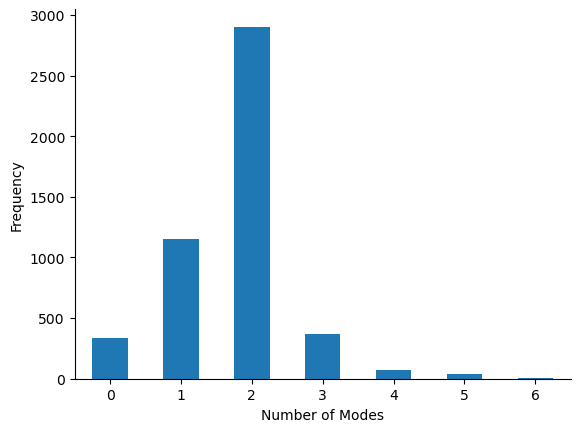

In [7]:
df = pd.read_pickle(os.path.join(modes_working_dir, "mode_analysis.pkl"))
df.groupby('modes', as_index=False).size()['size'].plot(kind='bar', rot=0)
matplotlib.rcParams.update({'axes.labelsize': 14})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
plt.xlabel("Number of Modes")
plt.ylabel("Frequency")
sns.despine()
fig = plt.gcf()
fig.savefig(f"{WORKING_DIR}/modes_analysis.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Independence analysis. 

Run ```python generate_independence_analysis.py```.

In [8]:
path_to_independence_df = f"{WORKING_DIR}/independence_analysis.pkl"

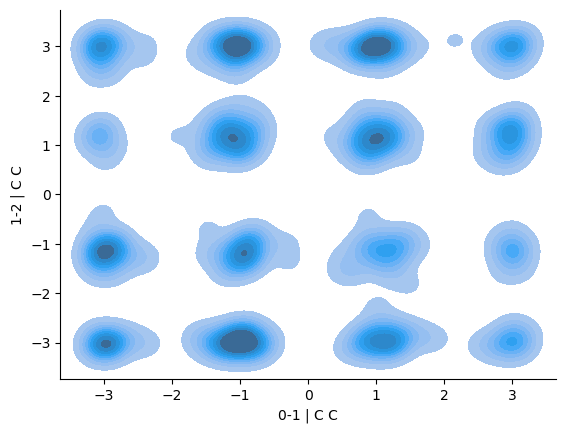

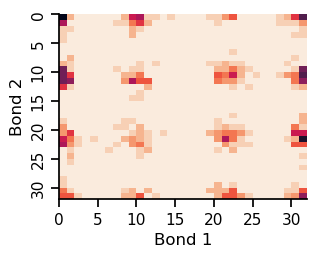

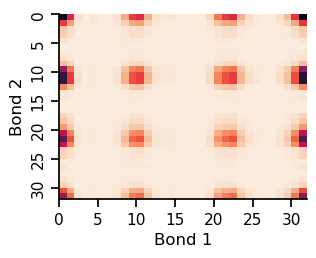

0.4742866041818533


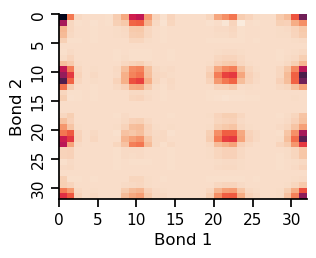

0.30765321854882044


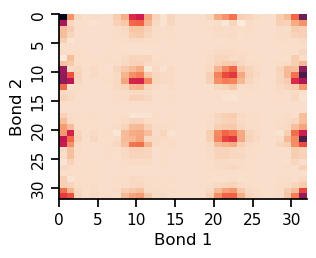

0.2102973942162944


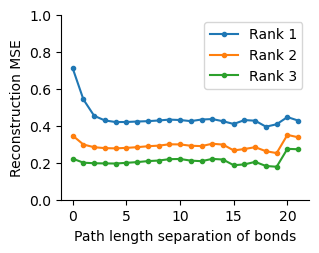

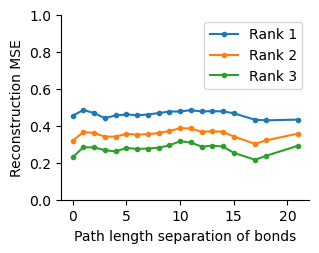

0.5071773619843458 0.3264181105001827


In [9]:
mol = Chem.Mol(open("data/visualization-demo-butane-pt-new-20221124.bin", "rb").read())
theta_bins = np.linspace(-np.pi, np.pi, 33)

tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
d = rdMolDraw2D.MolDraw2DSVG(500, 500)
d.drawOptions().addAtomIndices = False
hit_bonds = []
hit_atoms = []
hit_bonds.append(mol.GetBondBetweenAtoms(0, 1).GetIdx())
hit_bonds.append(mol.GetBondBetweenAtoms(1, 2).GetIdx())
hit_atoms += [0, 1]
hit_atoms += [1, 2]
rdMolDraw2D.PrepareAndDrawMolecule(d, tmp, highlightBonds=hit_bonds, highlightAtoms=hit_atoms)

with open(f"{WORKING_DIR}/butane_graph_highlight_bonds.svg", 'w') as f:
    f.write(d.GetDrawingText())
    
theta_bins = np.linspace(-np.pi, np.pi, 33)

# GT histogram
df_tmp = mol_utils.compute_rotatable_bond_torsions(mol)
hist = np.histogram2d(df_tmp.iloc[:, 0], df_tmp.iloc[:, 1], bins=theta_bins)
g = sns.kdeplot(x=df_tmp.iloc[:, 0], y=df_tmp.iloc[:, 1], fill=True, bw_adjust=0.25)
sns.despine()
plt.show()
plt.close()
with sns.plotting_context("notebook", font_scale=1):
    matplotlib.rcParams.update({'axes.labelsize': 12})
    g = sns.heatmap(hist[0], cmap="rocket_r", cbar=False)
    g.figure.set_size_inches(3.2, 2.4)
    g.set(xticks=[0, 5, 10, 15, 20, 25, 30], 
          xticklabels=[0, 5, 10, 15, 20, 25, 30],
         yticks=[0, 5, 10, 15, 20, 25, 30], 
          yticklabels=[0, 5, 10, 15, 20, 25, 30])
    plt.xlabel("Bond 1")
    plt.ylabel("Bond 2")
    sns.despine()
    g.figure.savefig(f"{WORKING_DIR}/hist_gt_32bin_butane.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

# Rank 1 reconstruction
U, sigma, VT = scipy.linalg.svd(hist[0])
approx_inc = np.outer(U[:, 0], VT[0]) * sigma[0]
with sns.plotting_context("notebook", font_scale=1):
    matplotlib.rcParams.update({'axes.labelsize': 12})
    g = sns.heatmap(approx_inc, cmap="rocket_r", cbar=False)
    g.figure.set_size_inches(3.2, 2.4)
    g.set(xticks=[0, 5, 10, 15, 20, 25, 30], 
          xticklabels=[0, 5, 10, 15, 20, 25, 30],
         yticks=[0, 5, 10, 15, 20, 25, 30], 
          yticklabels=[0, 5, 10, 15, 20, 25, 30])
    plt.xlabel("Bond 1")
    plt.ylabel("Bond 2")
    sns.despine()
    g.figure.savefig(f"{WORKING_DIR}/hist_rank1_32bin_butane.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()
print(np.square(hist[0] - approx_inc).mean())

# Rank 2 reconstruction
approx_inc += np.outer(U[:, 1], VT[1]) * sigma[1]
with sns.plotting_context("notebook", font_scale=1):
    matplotlib.rcParams.update({'axes.labelsize': 12})
    g = sns.heatmap(approx_inc, cmap="rocket_r", cbar=False)
    g.figure.set_size_inches(3.2, 2.4)
    g.set(xticks=[0, 5, 10, 15, 20, 25, 30], 
          xticklabels=[0, 5, 10, 15, 20, 25, 30],
         yticks=[0, 5, 10, 15, 20, 25, 30], 
          yticklabels=[0, 5, 10, 15, 20, 25, 30])
    plt.xlabel("Bond 1")
    plt.ylabel("Bond 2")
    sns.despine()
    g.figure.savefig(f"{WORKING_DIR}/hist_rank2_32bin_butane.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()

# Rank 3 reconstruction
print(np.square(hist[0] - approx_inc).mean())
approx_inc += np.outer(U[:, 2], VT[2]) * sigma[2]
with sns.plotting_context("notebook", font_scale=1):
    matplotlib.rcParams.update({'axes.labelsize': 12})
    g = sns.heatmap(approx_inc, cmap="rocket_r", cbar=False)
    g.figure.set_size_inches(3.2, 2.4)
    g.set(xticks=[0, 5, 10, 15, 20, 25, 30], 
          xticklabels=[0, 5, 10, 15, 20, 25, 30],
         yticks=[0, 5, 10, 15, 20, 25, 30], 
          yticklabels=[0, 5, 10, 15, 20, 25, 30])
    plt.xlabel("Bond 1")
    plt.ylabel("Bond 2")
    sns.despine()
    g.figure.savefig(f"{WORKING_DIR}/hist_rank3_32bin_butane.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()
print(np.square(hist[0] - approx_inc).mean())

df = pd.read_pickle(path_to_independence_df)
df_methyl = df[df['methyl_pair'] == True]

# matplotlib.rcParams.update({'font.size': 7})
plt.plot(df[df['rank'] == 1].drop(['bonds', 'methyl_pair', 'rank', 'mol_id'], axis=1).groupby(
    'path_length').mean(), label="Rank 1", marker='o', linestyle='-', markersize=3)
plt.plot(df[df['rank'] == 2].drop(['bonds', 'methyl_pair', 'rank', 'mol_id'], axis=1).groupby(
    'path_length').mean(), label="Rank 2", marker='o', linestyle='-', markersize=3)
plt.plot(df[df['rank'] == 3].drop(['bonds', 'methyl_pair', 'rank', 'mol_id'], axis=1).groupby(
    'path_length').mean(), label="Rank 3", marker='o', linestyle='-', markersize=3)
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
plt.xlabel("Path length separation of bonds")
plt.ylabel("Reconstruction MSE")
plt.legend()
plt.ylim((0, 1))
sns.despine()
fig.savefig(f"{WORKING_DIR}/mse_rank_reconstructions.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()
matplotlib.rcParams.update({'font.size': 10})

# matplotlib.rcParams.update({'font.size': 7})
plt.plot(df_methyl[df_methyl['rank'] == 1].drop(['bonds', 'methyl_pair', 'rank', 'mol_id'], axis=1).groupby(
    'path_length').mean(), label="Rank 1", marker='o', linestyle='-', markersize=3)
plt.plot(df_methyl[df_methyl['rank'] == 2].drop(['bonds', 'methyl_pair', 'rank', 'mol_id'], axis=1).groupby(
    'path_length').mean(), label="Rank 2", marker='o', linestyle='-', markersize=3)
plt.plot(df_methyl[df_methyl['rank'] == 3].drop(['bonds', 'methyl_pair', 'rank', 'mol_id'], axis=1).groupby(
    'path_length').mean(), label="Rank 3", marker='o', linestyle='-', markersize=3)
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
plt.xlabel("Path length separation of bonds")
plt.ylabel("Reconstruction MSE")
plt.legend()
plt.ylim((0, 1))
sns.despine()
fig.savefig(f"{WORKING_DIR}/mse_rank_constructions_methyl.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()
matplotlib.rcParams.update({'font.size': 10})
print(df[df['rank'] == 1]['mse'].mean(), df[df['rank'] == 1]['mse'].std())
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

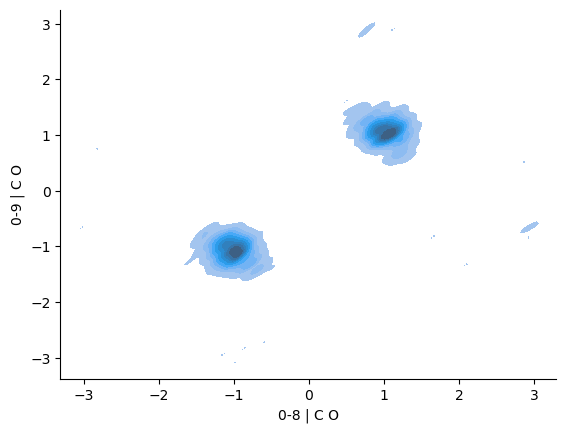

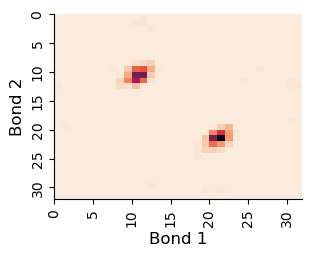

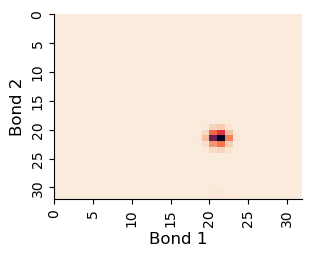

8.011784963271966


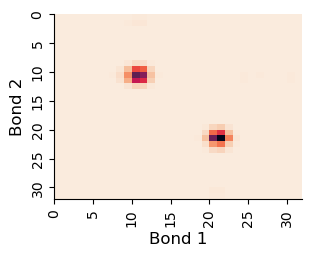

0.5282406312821577


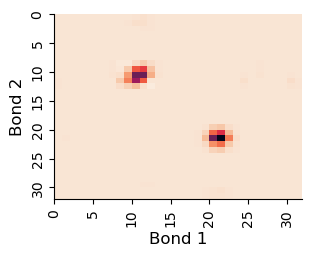

0.27853840947176156


In [11]:
db_session = create_session("data/mol-data/nmrshiftdb-pt-conf-mols.db")
stmt = select([Molecule]).where(Molecule.id == int(18209))
db_mol = db_session.execute(stmt).one()[0]
mol = Chem.Mol(db_mol.mol)
tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
d = rdMolDraw2D.MolDraw2DSVG(500, 500)
d.drawOptions().addAtomIndices = False
hit_bonds = []
hit_atoms = []
hit_bonds.append(mol.GetBondBetweenAtoms(0, 9).GetIdx())
hit_bonds.append(mol.GetBondBetweenAtoms(0, 8).GetIdx())
hit_atoms += [0, 9]
hit_atoms += [0, 8]
rdMolDraw2D.PrepareAndDrawMolecule(d, tmp, highlightBonds=hit_bonds, highlightAtoms=hit_atoms)

with open(f"{WORKING_DIR}/bad_rank_1_example.svg", 'w') as f:
    f.write(d.GetDrawingText())
    
theta_bins = np.linspace(-np.pi, np.pi, 33)

# GT histogram
df_tmp = mol_utils.compute_rotatable_bond_torsions(mol)
hist = np.histogram2d(df_tmp.iloc[:, 0], df_tmp.iloc[:, 1], bins=theta_bins)
g = sns.kdeplot(x=df_tmp.iloc[:, 1], y=df_tmp.iloc[:, 0], fill=True, bw_adjust=0.25)
sns.despine()
plt.show()
plt.close()
matplotlib.rcParams.update({'axes.labelsize': 12})
g = sns.heatmap(hist[0], cmap="rocket_r", cbar=False)
g.figure.set_size_inches(3.2, 2.4)
g.set(xticks=[0, 5, 10, 15, 20, 25, 30], 
      xticklabels=[0, 5, 10, 15, 20, 25, 30],
     yticks=[0, 5, 10, 15, 20, 25, 30], 
      yticklabels=[0, 5, 10, 15, 20, 25, 30])
plt.xlabel("Bond 1")
plt.ylabel("Bond 2")
sns.despine()
g.figure.savefig(f"{WORKING_DIR}/hist_gt_32bin_bad_rank1.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()

# Rank 1 reconstruction
U, sigma, VT = scipy.linalg.svd(hist[0])
approx_inc = np.outer(U[:, 0], VT[0]) * sigma[0]
matplotlib.rcParams.update({'axes.labelsize': 12})
g = sns.heatmap(approx_inc, cmap="rocket_r", cbar=False)
g.figure.set_size_inches(3.2, 2.4)
g.set(xticks=[0, 5, 10, 15, 20, 25, 30], 
      xticklabels=[0, 5, 10, 15, 20, 25, 30],
     yticks=[0, 5, 10, 15, 20, 25, 30], 
      yticklabels=[0, 5, 10, 15, 20, 25, 30])
plt.xlabel("Bond 1")
plt.ylabel("Bond 2")
sns.despine()
g.figure.savefig(f"{WORKING_DIR}/hist_rank1_32bin_bad_rank1.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()
print(np.square(hist[0] - approx_inc).mean())

# Rank 2 reconstruction
approx_inc += np.outer(U[:, 1], VT[1]) * sigma[1]
matplotlib.rcParams.update({'axes.labelsize': 12})
g = sns.heatmap(approx_inc, cmap="rocket_r", cbar=False)
g.figure.set_size_inches(3.2, 2.4)
g.set(xticks=[0, 5, 10, 15, 20, 25, 30], 
      xticklabels=[0, 5, 10, 15, 20, 25, 30],
     yticks=[0, 5, 10, 15, 20, 25, 30], 
      yticklabels=[0, 5, 10, 15, 20, 25, 30])
plt.xlabel("Bond 1")
plt.ylabel("Bond 2")
sns.despine()
g.figure.savefig(f"{WORKING_DIR}/hist_rank2_32bin_bad_rank1.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()

# Rank 3 reconstruction
print(np.square(hist[0] - approx_inc).mean())
approx_inc += np.outer(U[:, 2], VT[2]) * sigma[2]
matplotlib.rcParams.update({'axes.labelsize': 12})
g = sns.heatmap(approx_inc, cmap="rocket_r", cbar=False)
g.figure.set_size_inches(3.2, 2.4)
g.set(xticks=[0, 5, 10, 15, 20, 25, 30], 
      xticklabels=[0, 5, 10, 15, 20, 25, 30],
     yticks=[0, 5, 10, 15, 20, 25, 30], 
      yticklabels=[0, 5, 10, 15, 20, 25, 30])
plt.xlabel("Bond 1")
plt.ylabel("Bond 2")
sns.despine()
g.figure.savefig(f"{WORKING_DIR}/hist_rank3_32bin_bad_rank1.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()
print(np.square(hist[0] - approx_inc).mean())




Chirality example. 

In [74]:
def vonmises_kde(data, kappa, n_bins=100):
    from scipy.special import i0
    bins = np.linspace(-np.pi, np.pi, n_bins)
    x = np.linspace(-np.pi, np.pi, n_bins)
    # integrate vonmises kernels
    kde = np.exp(kappa*np.cos(x[:, None]-data[None, :])).sum(1)/(2*np.pi*i0(kappa))
    kde /= np.trapz(kde, x=bins)
    return bins, kde

Above is from: https://stackoverflow.com/questions/28839246/scipy-gaussian-kde-and-circular-data 

304
257


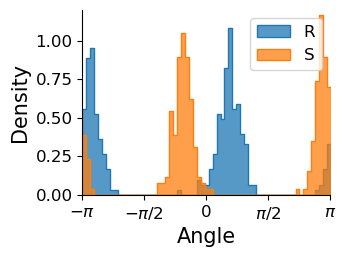

268
292


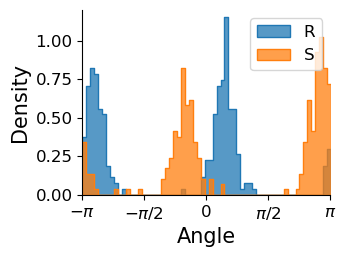

561
0


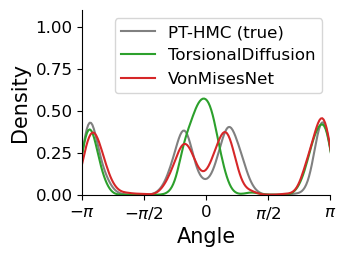

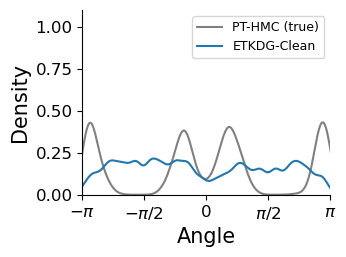

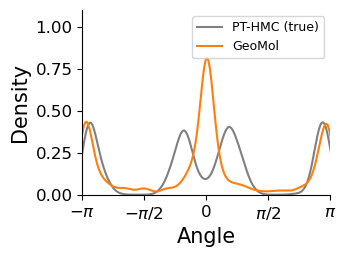

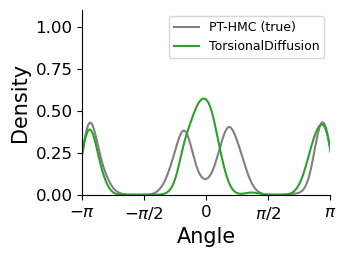

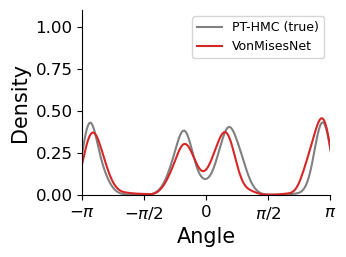

In [77]:
samples_db = sqlitedict.SqliteDict(f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", flag="r")
mol = samples_db['1126'].mol
df_full = mol_utils.compute_rotatable_bond_torsions(mol)

test = mol_utils.compute_chirality_all_confs(mol, 19)
tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
for idx in range(mol.GetNumConformers()):
    if test[idx] > 0:
        tmp.AddConformer(mol.GetConformers()[idx])
df_positive = mol_utils.compute_rotatable_bond_torsions(tmp)

print(tmp.GetNumConformers())

tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
for idx in range(mol.GetNumConformers()):
    if test[idx] < 0:
        tmp.AddConformer(mol.GetConformers()[idx])
df_negative = mol_utils.compute_rotatable_bond_torsions(tmp)

print(tmp.GetNumConformers())

# with sns.plotting_context("notebook", font_scale=0.8):
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
g = sns.histplot(df_positive['3-19 | C N'].to_numpy(), bins=list(np.arange(-math.pi - 1., math.pi + 1., 0.1)),
             stat='density', element='step', label='R')
g.figure.set_size_inches(3.,2.)
g = sns.histplot(df_negative['3-19 | C N'].to_numpy(), bins=list(np.arange(-math.pi - 1., math.pi + 1., 0.1)),
             stat='density', element='step', label='S')
g.figure.set_size_inches(3.2, 2.4)
plt.legend(fontsize=12)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim((-math.pi, math.pi))
plt.ylim((0, 1.2))
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.show()
g.figure.savefig("chirality_comparison_gt.pdf", format="pdf", bbox_inches="tight")
plt.clf()
plt.cla()
plt.close()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

vm_db = sqlitedict.SqliteDict(f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db",
                              flag="r")
mol = vm_db['1126'].mol
df_vm = mol_utils.compute_rotatable_bond_torsions(mol)

test = mol_utils.compute_chirality_all_confs(mol, 19)
tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
for idx in range(mol.GetNumConformers()):
    if test[idx] > 0:
        tmp.AddConformer(mol.GetConformers()[idx])
df_positive = mol_utils.compute_rotatable_bond_torsions(tmp)

print(tmp.GetNumConformers())

tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
for idx in range(mol.GetNumConformers()):
    if test[idx] < 0:
        tmp.AddConformer(mol.GetConformers()[idx])
df_negative = mol_utils.compute_rotatable_bond_torsions(tmp)

print(tmp.GetNumConformers())

# with sns.plotting_context("notebook", font_scale=0.8):
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
g = sns.histplot(df_positive['3-19 | C N'].to_numpy(), bins=list(np.arange(-math.pi - 1., math.pi + 1., 0.1)),
             stat='density', element='step', label='R')
g.figure.set_size_inches(3.2, 2.4)
g = sns.histplot(df_negative['3-19 | C N'].to_numpy(), bins=list(np.arange(-math.pi - 1., math.pi + 1., 0.1)),
             stat='density', element='step', label='S')
g.figure.set_size_inches(3.2, 2.4)
plt.legend(fontsize=12)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim((-math.pi, math.pi))
plt.ylim((0, 1.2))
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
g.figure.savefig("chirality_comparison_vm.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.clf()
plt.cla()
plt.close()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

torsional_db = sqlitedict.SqliteDict(f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/TorsionalDiffusion.db", flag="r")
mol = torsional_db['1126'].mol
df_torsional = mol_utils.compute_rotatable_bond_torsions(mol)

test = mol_utils.compute_chirality_all_confs(mol, 19)
tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
for idx in range(mol.GetNumConformers()):
    if test[idx] > 0:
        tmp.AddConformer(mol.GetConformers()[idx])
df_positive = mol_utils.compute_rotatable_bond_torsions(tmp)

print(tmp.GetNumConformers())

tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
for idx in range(mol.GetNumConformers()):
    if test[idx] < 0:
        tmp.AddConformer(mol.GetConformers()[idx])
df_negative = mol_utils.compute_rotatable_bond_torsions(tmp)

print(tmp.GetNumConformers())

etkdg_db = sqlitedict.SqliteDict(f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/ETKDG-Clean.db", flag="r")
mol = etkdg_db['1126'].mol
df_etkdg = mol_utils.compute_rotatable_bond_torsions(mol)

geomol_db = sqlitedict.SqliteDict(f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/GeoMol.db", flag="r")
mol = geomol_db['1126'].mol
df_geomol = mol_utils.compute_rotatable_bond_torsions(mol)

# with sns.plotting_context("notebook", font_scale=0.8):
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
g = sns.kdeplot(df_full['3-19 | C N'].to_numpy(), label='PT-HMC (true)', bw_adjust=0.25, color="grey")
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(df_torsional['3-19 | C N'].to_numpy(), label='TorsionalDiffusion', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(df_vm['3-19 | C N'].to_numpy(), label='VonMisesNet', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
plt.legend(fontsize=12)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.show()
g.figure.savefig("chirality_comparison_VM_vs_diffusion.pdf", format="pdf", bbox_inches="tight")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# with sns.plotting_context("notebook", font_scale=0.8):
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
g = sns.kdeplot(df_full['3-19 | C N'].to_numpy(), label='PT-HMC (true)', bw_adjust=0.25, color="grey")
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(df_etkdg['3-19 | C N'].to_numpy(), label='ETKDG-Clean', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='GeoMol', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='TorsionalDiffusion', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='VonMisesNet', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
plt.legend(fontsize=9)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.show()
g.figure.savefig("chirality_comparison_gt_vs_ETKDG.pdf", format="pdf", bbox_inches="tight")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    
# with sns.plotting_context("notebook", font_scale=0.8):
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
g = sns.kdeplot(df_full['3-19 | C N'].to_numpy(), label='PT-HMC (true)', bw_adjust=0.25, color="grey")
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='ETKDG-Clean', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(df_geomol['3-19 | C N'].to_numpy(), label='GeoMol', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='TorsionalDiffusion', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='VonMisesNet', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
plt.legend(fontsize=9)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.show()
g.figure.savefig("chirality_comparison_gt_vs_GeoMol.pdf", format="pdf", bbox_inches="tight")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    
# with sns.plotting_context("notebook", font_scale=0.8):
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
g = sns.kdeplot(df_full['3-19 | C N'].to_numpy(), label='PT-HMC (true)', bw_adjust=0.25, color="grey")
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='ETKDG-Clean', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='GeoMol', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(df_torsional['3-19 | C N'].to_numpy(), label='TorsionalDiffusion', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='VonMisesNet', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
plt.legend(fontsize=9)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.show()
g.figure.savefig("chirality_comparison_gt_vs_diffusion.pdf", format="pdf", bbox_inches="tight")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    
# with sns.plotting_context("notebook", font_scale=0.8):
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
g = sns.kdeplot(df_full['3-19 | C N'].to_numpy(), label='PT-HMC (true)', bw_adjust=0.25, color="grey")
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='ETKDG-Clean', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='GeoMol', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, label='TorsionalDiffusion', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(df_vm['3-19 | C N'].to_numpy(), label='VonMisesNet', bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
plt.legend(fontsize=9)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.show()
g.figure.savefig("chirality_comparison_gt_vs_VM.pdf", format="pdf", bbox_inches="tight")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

tmp = Chem.Mol(mol)
tmp.RemoveAllConformers()
d = rdMolDraw2D.MolDraw2DSVG(500, 500)
d.drawOptions().addAtomIndices = False
hit_bonds = []
hit_atoms = []
hit_bonds.append(mol.GetBondBetweenAtoms(3, 19).GetIdx())
hit_atoms += [3, 19]
rdMolDraw2D.PrepareAndDrawMolecule(d, tmp, highlightBonds=hit_bonds, highlightAtoms=hit_atoms)

with open("chirality_example_molecular_graph.svg", 'w') as f:
    f.write(d.GetDrawingText())

Let's try the same KDE plots as above but using a vonmises KDE instead of a Gaussian KDE.

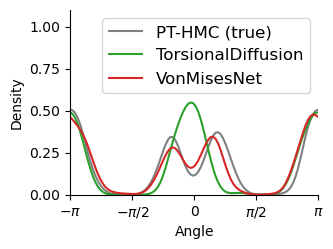

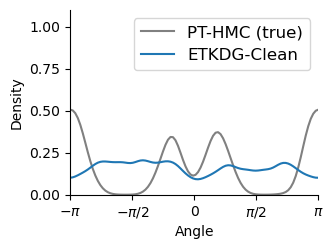

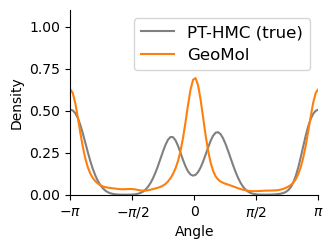

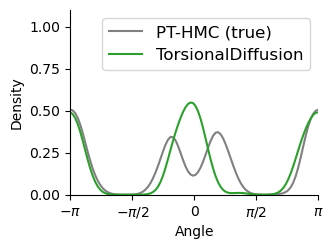

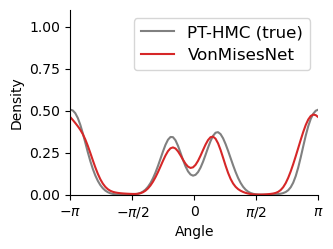

In [135]:
matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
x, kde = vonmises_kde(df_full['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='PT-HMC (true)', color="grey")
plt.plot([])
plt.plot([])
x, kde = vonmises_kde(df_torsional['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='TorsionalDiffusion')
x, kde = vonmises_kde(df_vm['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='VonMisesNet')
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
plt.legend(fontsize=12)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.savefig("chirality_comparison_VM_vs_diffusion_vonmisesKDE.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.close()
plt.clf()
plt.cla()

matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
x, kde = vonmises_kde(df_full['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='PT-HMC (true)', color="grey")
x, kde = vonmises_kde(df_etkdg['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='ETKDG-Clean')
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
plt.legend(fontsize=12)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.savefig("chirality_comparison_gt_vs_ETKDG_vonmisesKDE.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.close()
plt.clf()
plt.cla()

matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
x, kde = vonmises_kde(df_full['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='PT-HMC (true)', color="grey")
g = sns.kdeplot(None, bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
x, kde = vonmises_kde(df_geomol['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='GeoMol')
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
plt.legend(fontsize=12)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.savefig("chirality_comparison_gt_vs_GeoMol_vonmisesKDE.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.close()
plt.clf()
plt.cla()

matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
x, kde = vonmises_kde(df_full['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='PT-HMC (true)', color="grey")
g = sns.kdeplot(None, bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
x, kde = vonmises_kde(df_torsional['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='TorsionalDiffusion')
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
plt.legend(fontsize=12)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.savefig("chirality_comparison_gt_vs_diffusion_vonmisesKDE.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.close()
plt.clf()
plt.cla()

matplotlib.rcParams.update({'axes.labelsize': 15})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
x, kde = vonmises_kde(df_full['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='PT-HMC (true)', color="grey")
g = sns.kdeplot(None, bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
g = sns.kdeplot(None, bw_adjust=0.25)
g.figure.set_size_inches(3.2, 2.4)
x, kde = vonmises_kde(df_vm['3-19 | C N'].to_numpy(), 30)
plt.plot(x, kde, label='VonMisesNet')
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
plt.legend(fontsize=12)
plt.ylabel("Density")
plt.xlabel("Angle")
plt.xlim(-math.pi, math.pi)
plt.ylim(0., 1.1)
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
sns.despine()
plt.savefig("chirality_comparison_gt_vs_VM_vonmisesKDE.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.close()
plt.clf()
plt.cla()


Now we will generate the distance performance metrics results/plots. Run ```python generate_expectations_pipeline_wrapper.py```. When the job completes, run ```python generate_expectations_analysis_pipeline_wrapper.py```.

Optional: the steps above consume conformations generated by the trained models. To re-compute the conformations generated via ETKDG-Clean, VonMisesNet, VonMisesNet-Filtered, and the PT-HMC ground truth, delete the corresponding databases inside "conformation.dists-nmrshiftdb" and "conformation.dists-gdb", and then use the Ruffus pipeline in ```generate_distributions_pipeline.py``` to re-generate.

In [18]:
def comparison_bar_plot(all_model_names: List, all_mean_values: List, all_std_values: List, all_splits: List, ylabel: str, output_name: str, xlabel: str = None, xticks_font: int = 10, legend_font: int = 8, ylabel_font: int = 12, xlabel_font: int = 12, figsize: tuple = (6.4, 4.8), ylim: tuple = None, legend_loc: str = "best", no_legend: bool = False, colors = None, width_scale = 1.25):
    """
    Compare performance across multiple models on multiple splits.
    :return:
    """
    # Ensure all the same model names
    plt.close()
    plt.clf()
    plt.cla()
    assert all((all_model_names[i] == all_model_names[0]).all() for i in range(len(all_model_names)))

    all_mean_values = np.array(all_mean_values)
    all_std_values = np.array(all_std_values)

    model_names = all_model_names[0]
    num_splits = len(all_model_names)
    num_models = len(model_names)
    width = 1 / (width_scale * num_models)
    offset = width * num_models / 2

    # Plot the results for each model in this setting
    for i in range(num_models):
        model_name = model_names[i]
        mean_values = all_mean_values[:, i]
        std_values = all_std_values[:, i]
        if colors is not None:
            plt.bar(np.arange(num_splits) + i * width - offset, mean_values,
                    width=width, yerr=std_values, alpha=0.5, label=model_name, align='edge',
                    error_kw=dict(lw=1, capsize=2, capthick=1), color=colors[i]) 
        else:
            plt.bar(np.arange(num_splits) + i * width - offset, mean_values,
                    width=width, yerr=std_values, alpha=0.5, label=model_name, align='edge',
                    error_kw=dict(lw=1, capsize=2, capthick=1)) 
#         print(g.patches[0].get_facecolor())


    plt.xticks(np.arange(num_splits), all_splits, fontsize=xticks_font)
    plt.ylabel(ylabel, fontsize=ylabel_font)
    if not no_legend: 
        plt.legend(fontsize=legend_font, loc=legend_loc)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=xlabel_font)
    if ylim is not None:
        plt.ylim(ylim)
    sns.despine()
    fig = plt.gcf()
    fig.set_size_inches(figsize)
    
    return fig

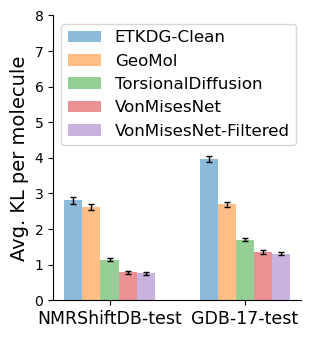

In [19]:
kl_per_mol_nmrshiftdb = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds/kl_all_lists.pkl"
res = pickle.load(open(kl_per_mol_nmrshiftdb, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], ["NMRShiftDB-test"]

kl_per_mol_gdb = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds/kl_all_lists.pkl"
res = pickle.load(open(kl_per_mol_gdb, "rb"))
all_model_names += res[0]
all_mean_values += res[1]
all_std_values += res[2]
all_splits += ["GDB-17-test"]
# fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. KL per molecule", "", figsize=(3.2, 2.3), legend_font=8, ylim=(0., 8.5), xticks_font=11.5, ylabel_font=14)
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. KL per molecule", "", figsize=(3.2, 3.7), legend_font=12, legend_loc="upper left", ylim=(0., 8), xticks_font=12.5, ylabel_font=14, width_scale=1.5)

fig.savefig(f"{WORKING_DIR}/kl_per_mol_rotatable_nmrshiftdb_gdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

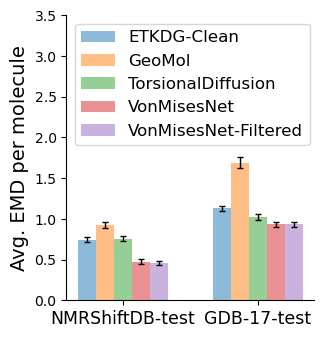

In [20]:
emd_per_mol_nmrshiftdb = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds/emd_dihedral.pkl"
res = pickle.load(open(emd_per_mol_nmrshiftdb, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], ["NMRShiftDB-test"]

emd_per_mol_gdb = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds/emd_dihedral.pkl"
res = pickle.load(open(emd_per_mol_gdb, "rb"))
all_model_names += res[0]
all_mean_values += res[1]
all_std_values += res[2]
all_splits += ["GDB-17-test"]

# fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD per molecule", "", figsize=(3.2, 2.3), legend_font=6)
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD per molecule", "", figsize=(3.2, 3.7), legend_font=12, legend_loc="upper left", ylim=(0., 3.5), xticks_font=12.5, ylabel_font=14, width_scale=1.5)
fig.savefig(f"{WORKING_DIR}/emd_per_mol_rotatable_nmrshiftdb_gdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

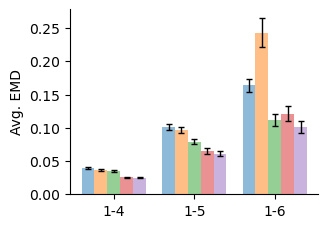

In [21]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "Avg. EMD", "", "", legend_font=8.5, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=10, xlabel_font=10, no_legend=True)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_rotatable_nmrshiftdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

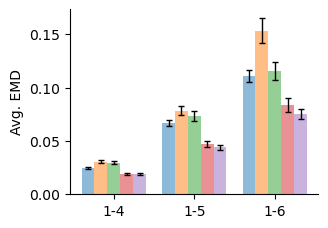

In [22]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-non-aromatic-ring/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "Avg. EMD", "", "", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=10, xlabel_font=10, no_legend=True)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_non_arom_nmrshiftdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

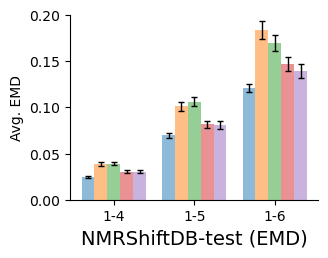

In [23]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-all/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "Avg. EMD", "", "NMRShiftDB-test (EMD)", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=10, xlabel_font=14, ylim=(0., .2), no_legend=True)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_all_nmrshiftdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

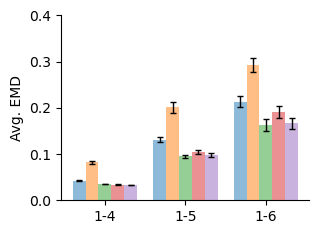

In [24]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-2], all_mean_values[:-2], all_std_values[:-2], all_splits[:-2], "Avg. EMD", "", "", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=10, xlabel_font=10, ylim=(0, 0.4), no_legend=True)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_rotatable_gdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

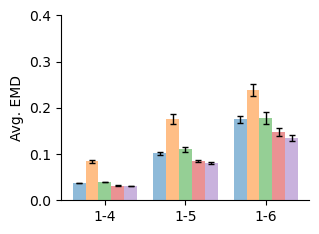

In [25]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-non-aromatic-ring/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "Avg. EMD", "", "", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=10, xlabel_font=10, ylim=(0, 0.4), no_legend=True)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_non_arom_gdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

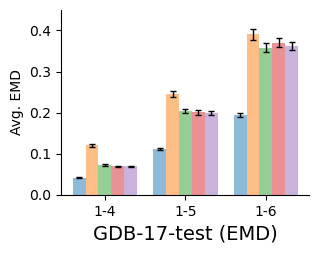

In [26]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-all/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "Avg. EMD", "", "GDB-17-test (EMD)", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=10, xlabel_font=14, ylim=(0, 0.45), no_legend=True)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_all_gdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

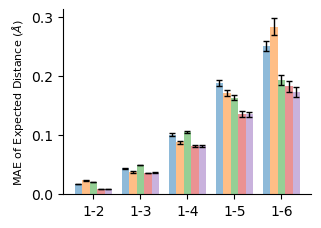

In [27]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "MAE of Expected Distance ($\AA$)", "", "", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=8, xlabel_font=10, no_legend=True)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_rotatable_nmrshiftdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

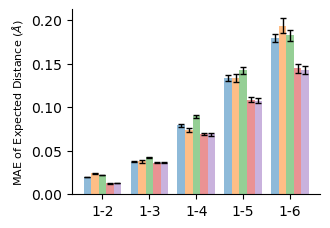

In [28]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-non-aromatic-ring/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "MAE of Expected Distance ($\AA$)", "", "", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=8, xlabel_font=10, no_legend=True)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_non_arom_nmrshiftdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

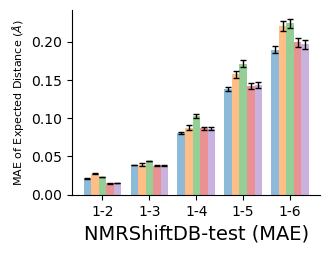

In [29]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-all/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "MAE of Expected Distance ($\AA$)", "", "NMRShiftDB-test (MAE)", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=8, xlabel_font=14, no_legend=True)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_all_nmrshiftdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

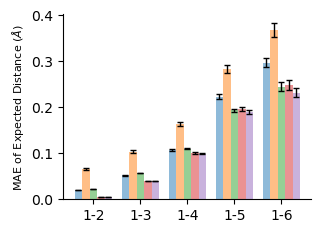

In [30]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-2], all_mean_values[:-2], all_std_values[:-2], all_splits[:-2], "MAE of Expected Distance ($\AA$)", "", "", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=8, xlabel_font=10, no_legend=True)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_rotatable_gdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

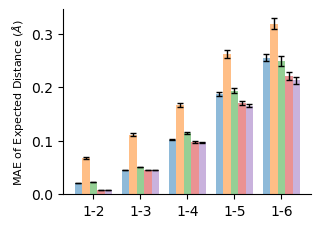

In [31]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-non-aromatic-ring/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "MAE of Expected Distance ($\AA$)", "", "", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=8, xlabel_font=10, no_legend=True)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_non_arom_gdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

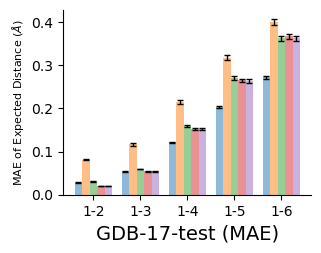

In [32]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-all/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names[:-4], all_mean_values[:-4], all_std_values[:-4], all_splits[:-4], "MAE of Expected Distance ($\AA$)", "", "GDB-17-test (MAE)", legend_font=7, xticks_font=10, figsize=(3.2, 2.4), ylabel_font=8, xlabel_font=14, no_legend=True)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_all_gdb.pdf", format="pdf", bbox_inches="tight")
plt.show()

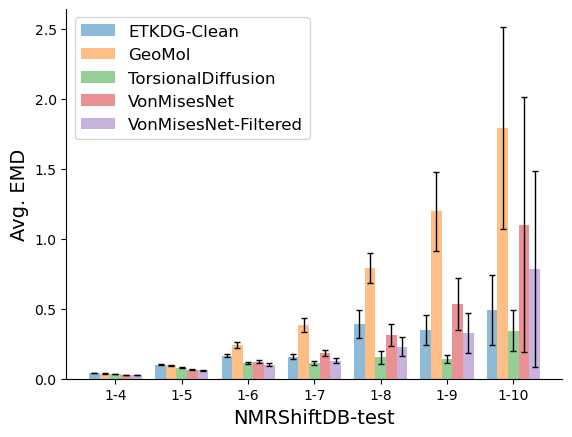

In [33]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "NMRShiftDB-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_rotatable_nmrshiftdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

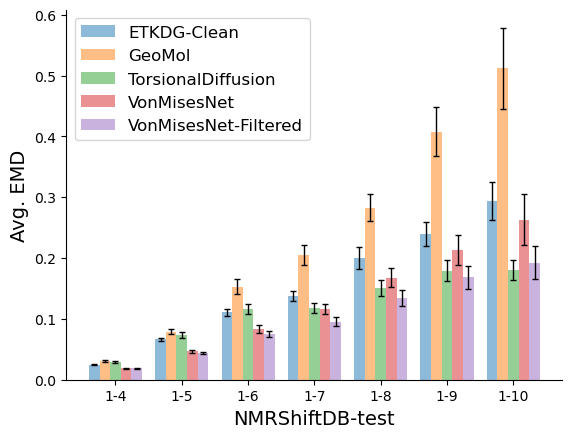

In [34]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-non-aromatic-ring/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "NMRShiftDB-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_non_arom_nmrshiftdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

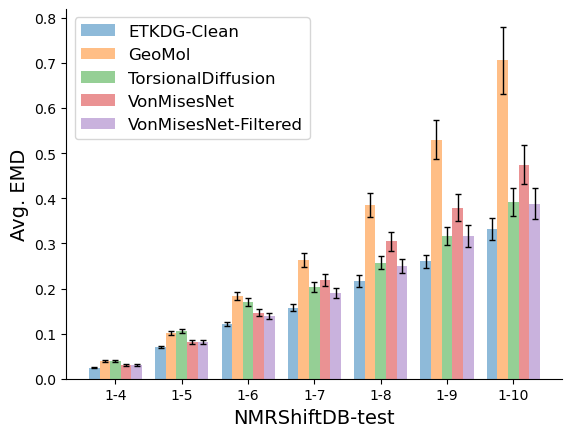

In [35]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-all/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "NMRShiftDB-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_all_nmrshiftdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

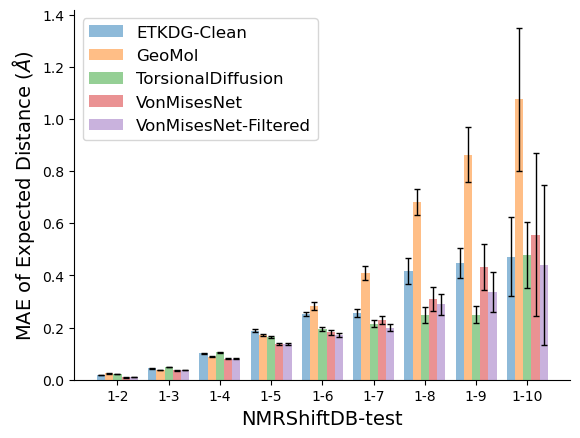

In [36]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "NMRShiftDB-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_rotatable_nmrshiftdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

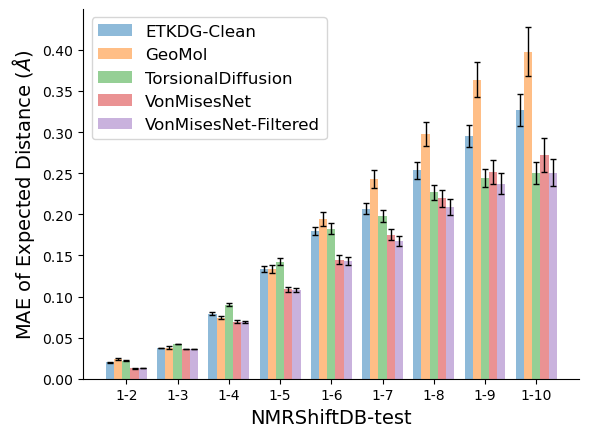

In [37]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-non-aromatic-ring/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "NMRShiftDB-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_non_arom_nmrshiftdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

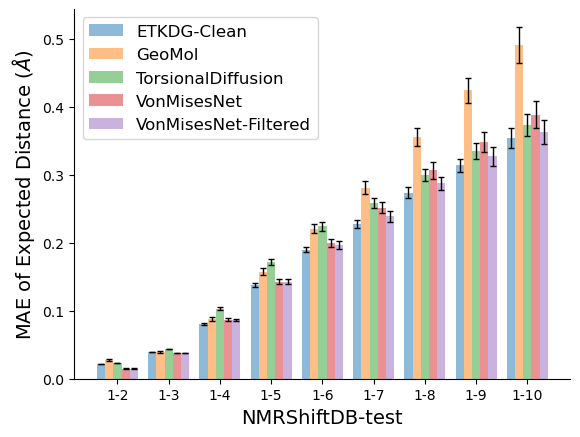

In [38]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-all/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "NMRShiftDB-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_all_nmrshiftdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

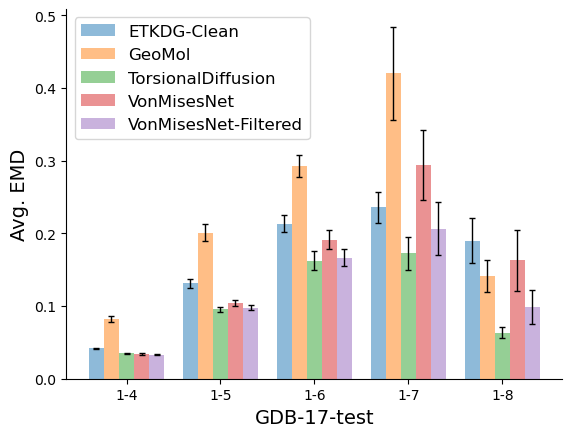

In [39]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "GDB-17-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_rotatable_gdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

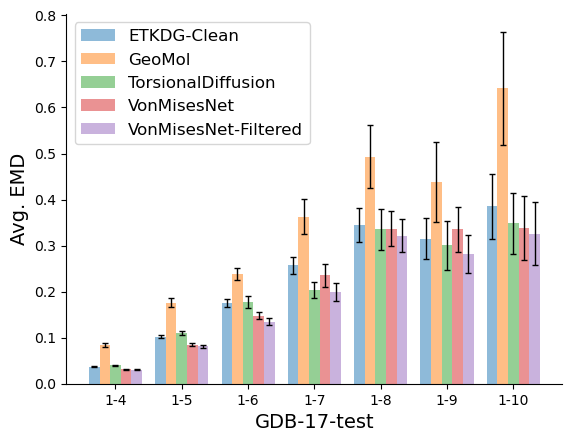

In [40]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-non-aromatic-ring/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "GDB-17-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_non_arom_gdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

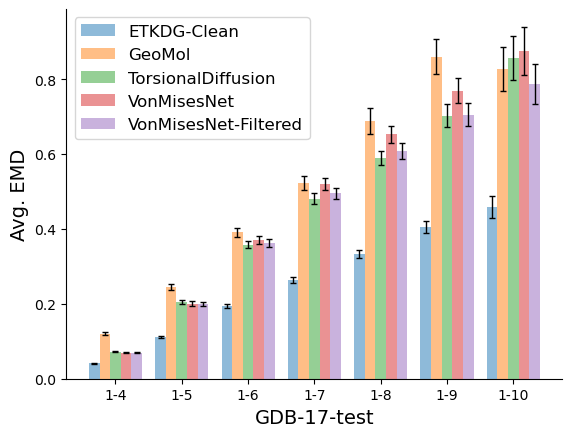

In [41]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-all/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "GDB-17-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_all_gdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

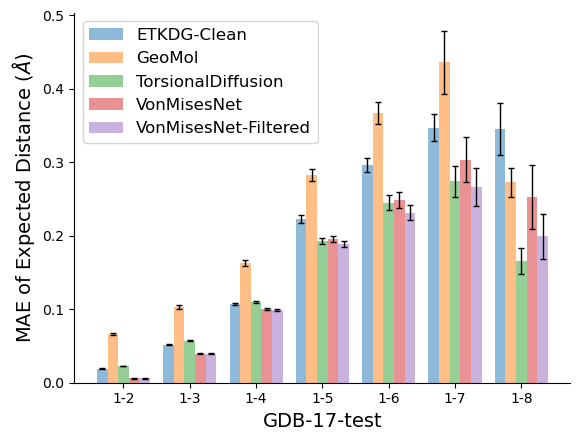

In [42]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "GDB-17-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_rotatable_gdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

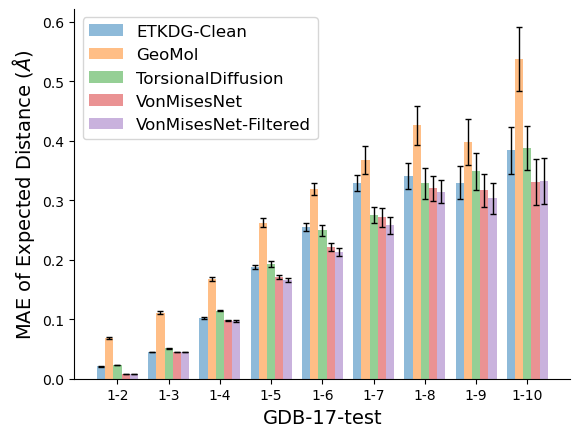

In [43]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-non-aromatic-ring/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "GDB-17-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_non_arom_gdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

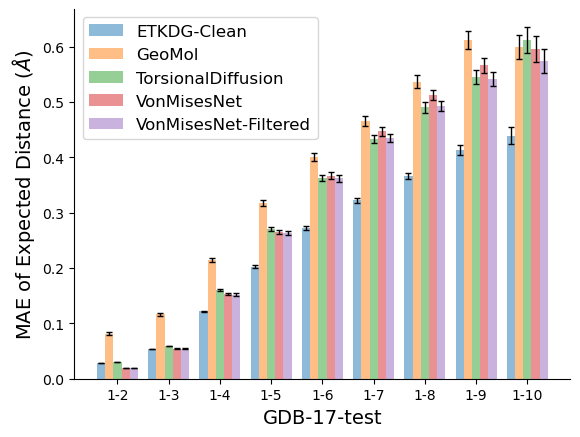

In [44]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-all/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "GDB-17-test", legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_all_gdb_extended.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [45]:
color_vectors = [[0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 0.5], 
                 [1.0, 0.4980392156862745, 0.054901960784313725, 0.5], 
                 [0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 0.5], 
                 [0.5803921568627451, 0.403921568627451, 0.7411764705882353, 0.5]]

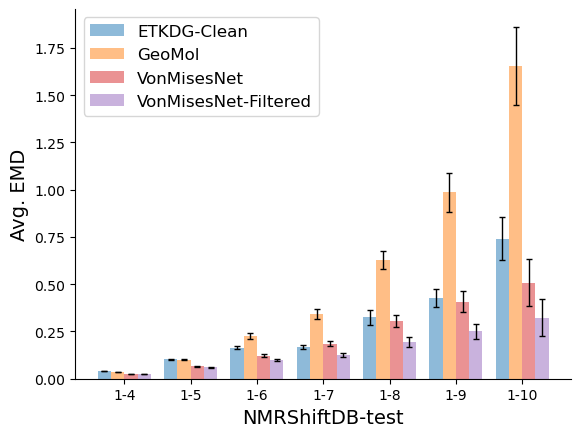

In [46]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds-ex-torsional/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "NMRShiftDB-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_rotatable_nmrshiftdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

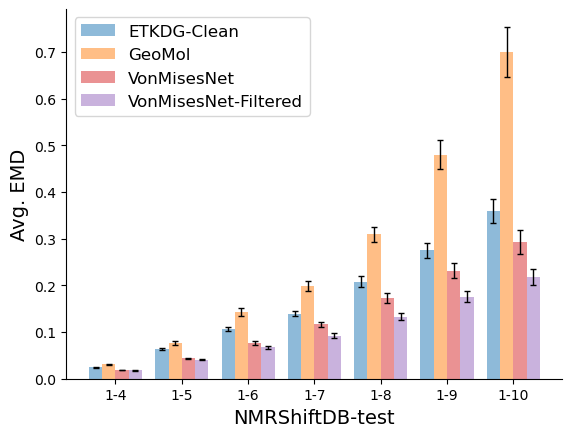

In [47]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-non-aromatic-ring-ex-torsional/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "NMRShiftDB-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_non_arom_nmrshiftdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

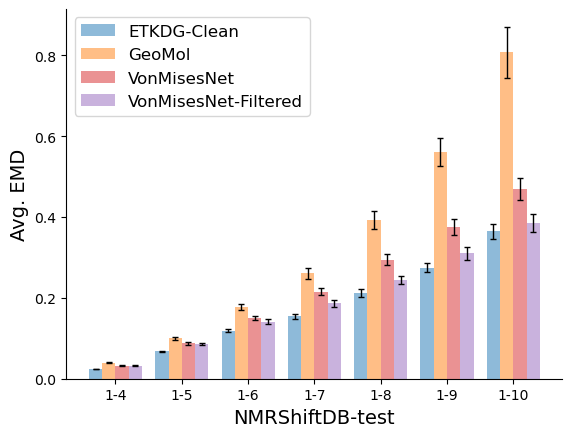

In [48]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-all-ex-torsional/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "NMRShiftDB-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_all_nmrshiftdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

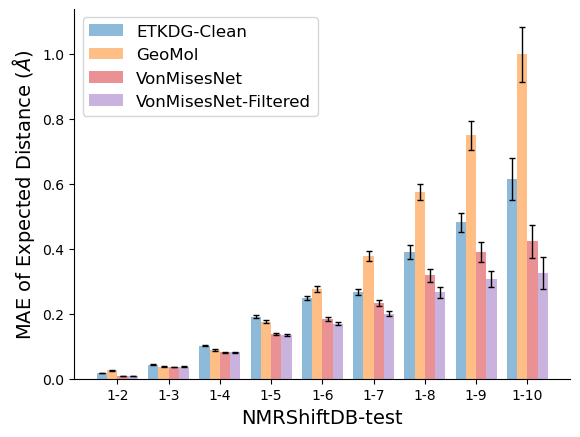

In [49]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds-ex-torsional/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "NMRShiftDB-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_rotatable_nmrshiftdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

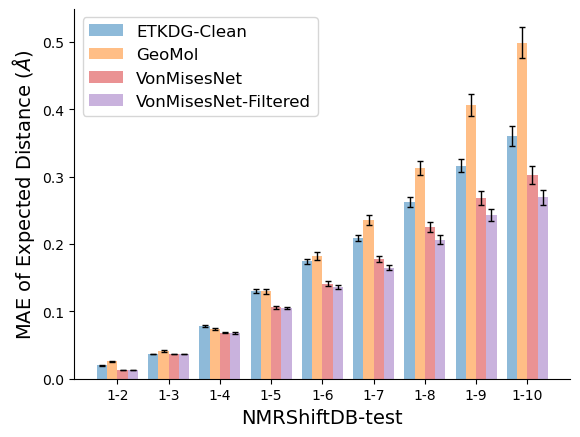

In [50]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-non-aromatic-ring-ex-torsional/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "NMRShiftDB-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_non_arom_nmrshiftdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

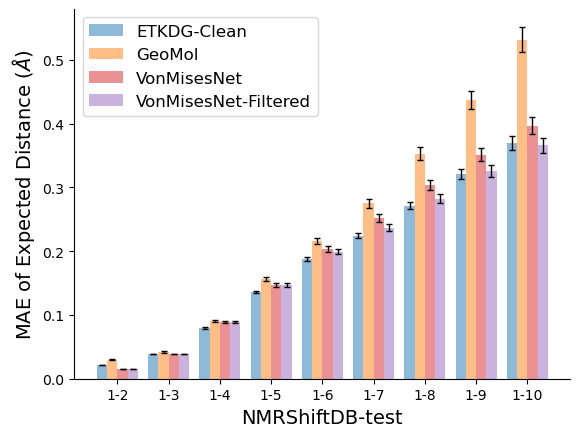

In [51]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-all-ex-torsional/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "NMRShiftDB-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_all_nmrshiftdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

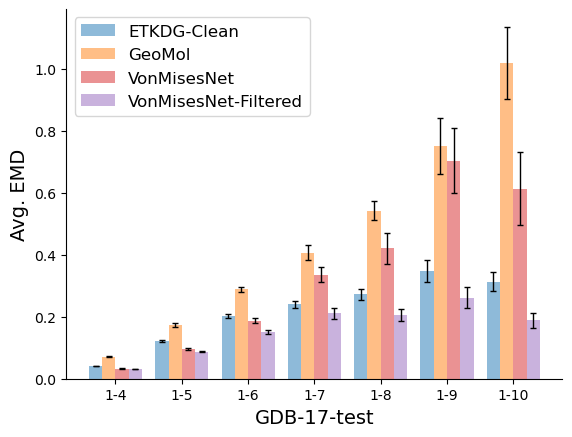

In [52]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds-ex-torsional/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "GDB-17-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_rotatable_gdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

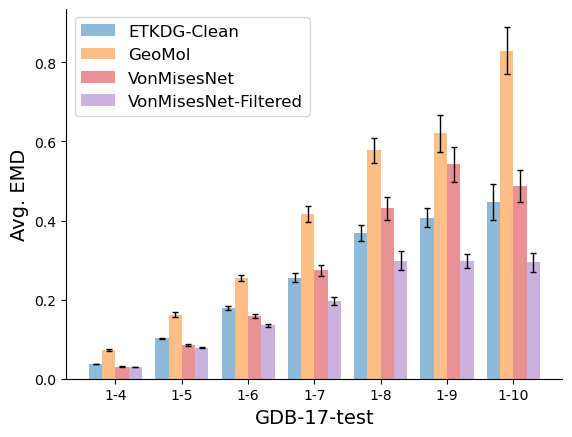

In [53]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-non-aromatic-ring-ex-torsional/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "GDB-17-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_non_arom_gdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

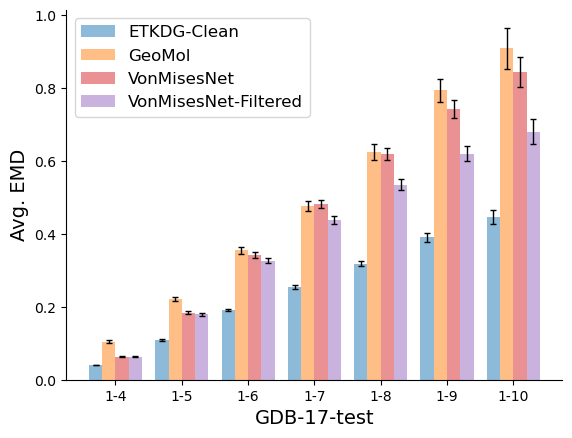

In [54]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-all-ex-torsional/mae_emd_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD", "", "GDB-17-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/avg_emd_per_molecule_barplot_all_gdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

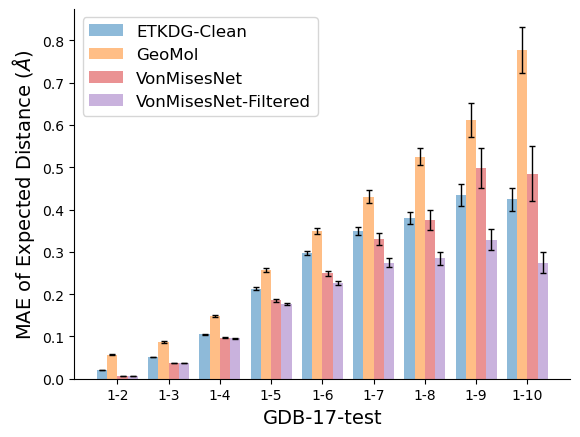

In [55]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds-ex-torsional/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "GDB-17-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_rotatable_gdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

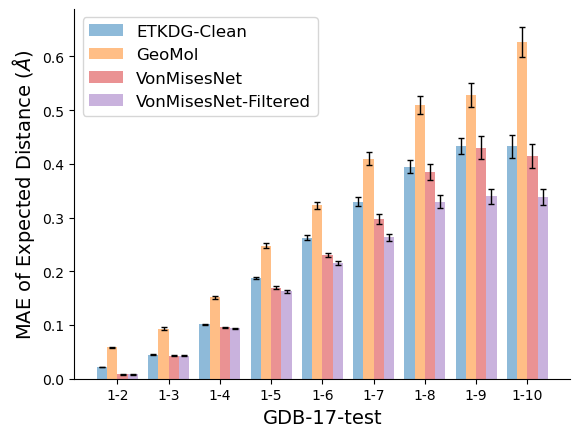

In [56]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-non-aromatic-ring-ex-torsional/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "GDB-17-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_non_arom_gdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

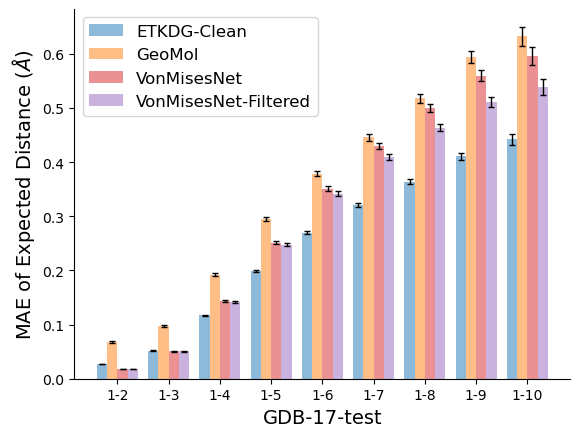

In [57]:
emd_per_mol = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-all-ex-torsional/mae_expected_distance_per_molecule_all_lists.pkl"
res = pickle.load(open(emd_per_mol, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], res[3]
fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "MAE of Expected Distance ($\AA$)", "", "GDB-17-test", colors=color_vectors, legend_font=12, ylabel_font=14, xlabel_font=14)
fig.savefig(f"{WORKING_DIR}/mae_expected_distance_per_mol_barplot_all_gdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

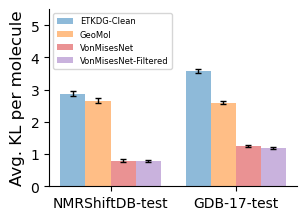

In [58]:
kl_per_mol_nmrshiftdb = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds-ex-torsional/kl_all_lists.pkl"
res = pickle.load(open(kl_per_mol_nmrshiftdb, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], ["NMRShiftDB-test"]

kl_per_mol_gdb = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds-ex-torsional/kl_all_lists.pkl"
res = pickle.load(open(kl_per_mol_gdb, "rb"))
all_model_names += res[0]
all_mean_values += res[1]
all_std_values += res[2]
all_splits += ["GDB-17-test"]

fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. KL per molecule", "", figsize=(3.2, 2.3), legend_font=6, ylim=(0., 5.5), legend_loc="upper left", colors=color_vectors)
fig.savefig(f"{WORKING_DIR}/kl_per_mol_rotatable_nmrshiftdb_gdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

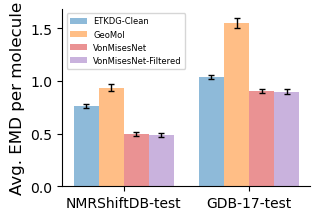

In [59]:
emd_per_mol_nmrshiftdb = f"{WORKING_DIR}/conformation.expectations-analysis-nmrshiftdb-vm-preds-ex-torsional/emd_dihedral.pkl"
res = pickle.load(open(emd_per_mol_nmrshiftdb, "rb"))
all_model_names, all_mean_values, all_std_values, all_splits = res[0], res[1], res[2], ["NMRShiftDB-test"]

emd_per_mol_gdb = f"{WORKING_DIR}/conformation.expectations-analysis-gdb-vm-preds-ex-torsional/emd_dihedral.pkl"
res = pickle.load(open(emd_per_mol_gdb, "rb"))
all_model_names += res[0]
all_mean_values += res[1]
all_std_values += res[2]
all_splits += ["GDB-17-test"]

fig = comparison_bar_plot(all_model_names, all_mean_values, all_std_values, all_splits, "Avg. EMD per molecule", "", figsize=(3.2, 2.3), legend_font=6, colors=color_vectors)
fig.savefig(f"{WORKING_DIR}/emd_per_mol_rotatable_nmrshiftdb_gdb_extended_ex_torsional.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [60]:
def generate_example_plots(mol_num, col, samples_db_path, vm_db_path, plot_save_path, graph_save_path, ylim=None, legend_font=None):
    matplotlib.rcParams.update({'axes.labelsize': 15})
    matplotlib.rcParams.update({'xtick.labelsize': 12})
    matplotlib.rcParams.update({'ytick.labelsize': 12})
    """Generate example rotatable bond plots."""
    samples_db = sqlitedict.SqliteDict(samples_db_path, flag="r")
    mol = samples_db[mol_num].mol
    df_full = mol_utils.compute_rotatable_bond_torsions(mol)
    atom_idx_1, atom_idx_2 = int(df_full.columns[col].split(" ")[0].split("-")[0]), int(df_full.columns[col].split(" ")[0].split("-")[1])
    df_full = df_full.iloc[:, col]
    
    vm_db = sqlitedict.SqliteDict(vm_db_path, flag="r")
    mol = vm_db[mol_num].mol
    df_vm = mol_utils.compute_rotatable_bond_torsions(mol)
    df_vm = df_vm.iloc[:, col]
    
    df = pd.DataFrame(df_full.to_numpy())
    df[1] = pd.DataFrame(df_vm.to_numpy())
    df.columns = ["PT-HMC", "VonMisesNet"]
    
    g = sns.kdeplot(df_full.to_numpy(), label='PT-HMC (true)', bw_adjust=0.25, color="grey")
    g = sns.kdeplot(None)
    g = sns.kdeplot(None)
    g = sns.kdeplot(None)
    g = sns.kdeplot(df_vm.to_numpy(), label='VonMisesNet', bw_adjust=0.25)
    g.figure.set_size_inches(3.2, 2.4)
    g.set(xlim=(-math.pi, math.pi), 
      xticks=[-math.pi, 0., math.pi], 
      xticklabels=['$-\pi$', 0, '$\pi$'])
    plt.legend(fontsize=6)
    plt.ylabel("Density")
    plt.xlabel("Angle")
    if ylim is not None:
        plt.ylim(ylim)
    if legend_font is not None:
        plt.legend(fontsize=legend_font)
    sns.despine()
    plt.show()
    g.figure.savefig(plot_save_path, format="pdf", bbox_inches="tight")
    
    emd = ot.emd2_1d(df_full.to_numpy(), df_vm.to_numpy(),
           [1./len(df_full.to_numpy())]*len(df_full.to_numpy()),
           [1./len(df_vm.to_numpy())]*len(df_vm.to_numpy()))
    print(f"EMD: {emd}")

    hist_pt = np.histogram(df_full.to_numpy(), bins=32)[0]
    hist_pt = hist_pt / np.sum(hist_pt)
    hist_pt = np.where(hist_pt < 1e-10, 1e-10, hist_pt)

    hist_vm = np.histogram(df_vm.to_numpy(), bins=32)[0]
    hist_vm = hist_vm / np.sum(hist_vm)
    hist_vm = np.where(hist_vm < 1e-10, 1e-10, hist_vm)

    print(f"KL: {entropy(hist_vm, hist_pt)}")

    tmp = Chem.Mol(mol)
    tmp.RemoveAllConformers()
    d = rdMolDraw2D.MolDraw2DSVG(320, 240)
    d.drawOptions().addAtomIndices = False
    hit_bonds = []
    hit_atoms = []
    hit_bonds.append(mol.GetBondBetweenAtoms(atom_idx_1, atom_idx_2).GetIdx())
    hit_atoms += [atom_idx_1, atom_idx_2]
    rdMolDraw2D.PrepareAndDrawMolecule(d, tmp, highlightBonds=hit_bonds, highlightAtoms=hit_atoms)

    with open(graph_save_path, 'w') as f:
        f.write(d.GetDrawingText())
        
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

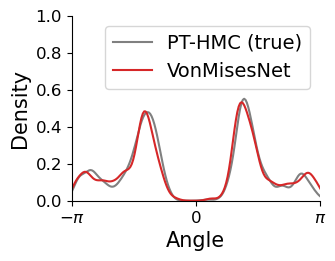

EMD: 0.09408797877611627
KL: 0.10771564019780017


In [141]:
generate_example_plots('160', 2, f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db", f"{WORKING_DIR}/example_nmr_160.pdf", f"{WORKING_DIR}/example_nmr_160_graph.svg", ylim=(0., 1.), legend_font=14)

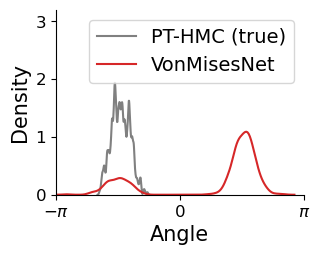

EMD: 7.045731888143776
KL: 3.1916001596432273


In [62]:
generate_example_plots('7528', 1, f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db", "example_nmr_7528.pdf", "example_nmr_7528_graph.svg", ylim=(0., 3.2), legend_font=14)

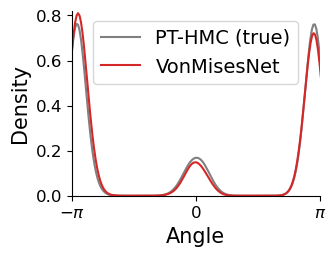

EMD: 0.3348368665893756
KL: 0.023784791141690156


In [63]:
generate_example_plots('9598', 1, f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db", "example_nmr_9598.pdf", "example_nmr_9598_graph.svg", legend_font=14, ylim=(0, 0.82))

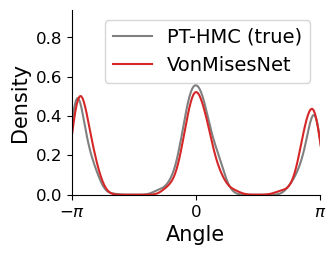

EMD: 0.23377232608154672
KL: 0.24795814657877152


In [64]:
generate_example_plots('19178', 0, f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db", "example_nmr_19178.pdf", "example_nmr_19178_graph.svg", ylim=(0., 0.94), legend_font=14)

In [136]:
def generate_example_plots_vonmises_kde(mol_num, col, samples_db_path, vm_db_path, plot_save_path, graph_save_path, ylim=None, legend_font=None):
    matplotlib.rcParams.update({'axes.labelsize': 15})
    matplotlib.rcParams.update({'xtick.labelsize': 12})
    matplotlib.rcParams.update({'ytick.labelsize': 12})
    """Generate example rotatable bond plots."""
    samples_db = sqlitedict.SqliteDict(samples_db_path, flag="r")
    mol = samples_db[mol_num].mol
    df_full = mol_utils.compute_rotatable_bond_torsions(mol)
    atom_idx_1, atom_idx_2 = int(df_full.columns[col].split(" ")[0].split("-")[0]), int(df_full.columns[col].split(" ")[0].split("-")[1])
    df_full = df_full.iloc[:, col]
    
    vm_db = sqlitedict.SqliteDict(vm_db_path, flag="r")
    mol = vm_db[mol_num].mol
    df_vm = mol_utils.compute_rotatable_bond_torsions(mol)
    df_vm = df_vm.iloc[:, col]
    
    df = pd.DataFrame(df_full.to_numpy())
    df[1] = pd.DataFrame(df_vm.to_numpy())
    df.columns = ["PT-HMC", "VonMisesNet"]
    

    x, kde = vonmises_kde(df_full.to_numpy(), 30)
    plt.plot(x, kde, label='PT-HMC (true)', color="grey")
    g = sns.kdeplot(None)
    g = sns.kdeplot(None)
    g = sns.kdeplot(None)
    x, kde = vonmises_kde(df_vm.to_numpy(), 30)
    plt.plot(x, kde, label='VonMisesNet')
    fig = plt.gcf()
    fig.set_size_inches(3.2, 2.4)
    plt.legend(fontsize=6)
    plt.ylabel("Density")
    plt.xlabel("Angle")
    plt.xlim(-math.pi, math.pi)
    plt.ylim(0., 1.1)
    plt.xticks([-math.pi, 0., math.pi], ['$-\pi$', 0, '$\pi$'])
    if ylim is not None:
        plt.ylim(ylim)
    if legend_font is not None:
        plt.legend(fontsize=legend_font)
    sns.despine()
    plt.savefig(plot_save_path, format="pdf", bbox_inches="tight")
    plt.show()
    plt.close()
    plt.clf()
    plt.cla()
    
    emd = ot.emd2_1d(df_full.to_numpy(), df_vm.to_numpy(),
           [1./len(df_full.to_numpy())]*len(df_full.to_numpy()),
           [1./len(df_vm.to_numpy())]*len(df_vm.to_numpy()))
    print(f"EMD: {emd}")

    hist_pt = np.histogram(df_full.to_numpy(), bins=32)[0]
    hist_pt = hist_pt / np.sum(hist_pt)
    hist_pt = np.where(hist_pt < 1e-10, 1e-10, hist_pt)

    hist_vm = np.histogram(df_vm.to_numpy(), bins=32)[0]
    hist_vm = hist_vm / np.sum(hist_vm)
    hist_vm = np.where(hist_vm < 1e-10, 1e-10, hist_vm)

    print(f"KL: {entropy(hist_vm, hist_pt)}")

    tmp = Chem.Mol(mol)
    tmp.RemoveAllConformers()
    d = rdMolDraw2D.MolDraw2DSVG(320, 240)
    d.drawOptions().addAtomIndices = False
    hit_bonds = []
    hit_atoms = []
    hit_bonds.append(mol.GetBondBetweenAtoms(atom_idx_1, atom_idx_2).GetIdx())
    hit_atoms += [atom_idx_1, atom_idx_2]
    rdMolDraw2D.PrepareAndDrawMolecule(d, tmp, highlightBonds=hit_bonds, highlightAtoms=hit_atoms)

    with open(graph_save_path, 'w') as f:
        f.write(d.GetDrawingText())
        
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

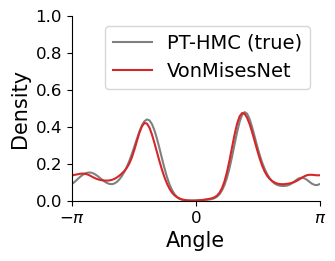

EMD: 0.09408797877611627
KL: 0.10771564019780017


In [142]:
generate_example_plots_vonmises_kde('160', 2, f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db", "example_nmr_160_vonmises_kde.pdf", "example_nmr_160_graph.svg", ylim=(0., 1.), legend_font=14)

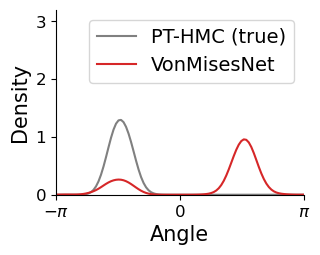

EMD: 7.045731888143776
KL: 3.1916001596432273


In [143]:
generate_example_plots_vonmises_kde('7528', 1, f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db", "example_nmr_7528_vonmises_kde.pdf", "example_nmr_7528_graph.svg", ylim=(0., 3.2), legend_font=14)

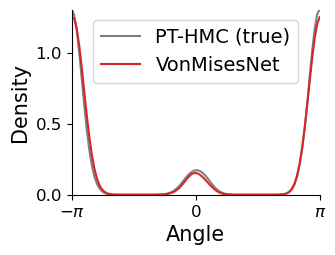

EMD: 0.3348368665893756
KL: 0.023784791141690156


In [144]:
generate_example_plots_vonmises_kde('9598', 1, f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db", "example_nmr_9598_vonmises_kde.pdf", "example_nmr_9598_graph.svg", legend_font=14, ylim=(0, 1.3))

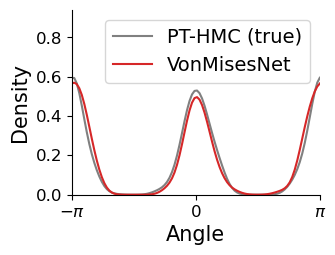

EMD: 0.23377232608154672
KL: 0.24795814657877152


In [145]:
generate_example_plots_vonmises_kde('19178', 0, f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/samples.db", f"{WORKING_DIR}/conformation.dists-nmrshiftdb-specific-examples/VonMisesNet.db", "example_nmr_19178_vonmises_kde.pdf", "example_nmr_19178_graph.svg", ylim=(0., 0.94), legend_font=14)

Let's plot an example of a von Mises mixture distribution.

In [65]:
loc = torch.tensor([[math.pi, -1.25, 1.25, 0]])
concentration = torch.tensor([[10., 10., 10., 10.]])
weights = torch.tensor([[1./3., 1./3., 1./3., 0.]])

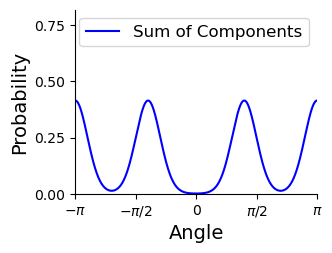

In [66]:
data = torch.tensor(np.linspace(-math.pi, math.pi, 1000))
num_von_mises = loc.shape[1]
num_bonds = loc.shape[0]

fig = plt.figure(constrained_layout=False)
gs = fig.add_gridspec(num_bonds, num_bonds)
ax = fig.add_subplot(gs[0, 0])


for j in range(num_bonds):
    prob = torch.zeros(len(data))
    for i in range(num_von_mises):
        prob += torch.tensor([weights[j][i]]) * torch.exp(
            VonMises(torch.tensor([loc[j][i]]), torch.tensor([concentration[j][i]])).log_prob(data))

    ax.plot(data, prob, color='blue', label="Sum of Components")
    
plt.ylabel("Probability", fontsize=14)
plt.xlabel("Angle", fontsize=14)
sns.despine()
matplotlib.rcParams.update({'xtick.labelsize': 14})
matplotlib.rcParams.update({'ytick.labelsize': 14})
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
plt.xlim((-math.pi, math.pi))
plt.ylim((0, 0.82))
plt.legend(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
fig.savefig(f"{WORKING_DIR}/von_mises_mixture_example_sum.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

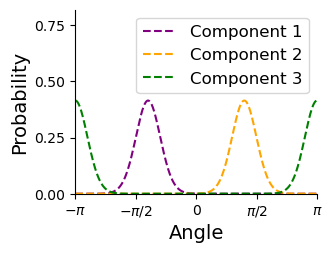

In [67]:
data = torch.tensor(np.linspace(-math.pi, math.pi, 1000))
num_von_mises = loc.shape[1]
num_bonds = loc.shape[0]
fig = plt.figure(constrained_layout=False)
gs = fig.add_gridspec(num_bonds, num_bonds)
ax = fig.add_subplot(gs[j, j])


i=1
prob = torch.tensor([weights[j][i]]) * torch.exp(VonMises(torch.tensor([loc[j][i]]), torch.tensor([concentration[j][i]])).log_prob(data))
ax.plot(data, prob, linestyle='--', label="Component 1", color="purple")

i=2
prob = torch.tensor([weights[j][i]]) * torch.exp(VonMises(torch.tensor([loc[j][i]]), torch.tensor([concentration[j][i]])).log_prob(data))
ax.plot(data, prob, linestyle='--', label="Component 2", color="orange")

i=0
prob = torch.tensor([weights[j][i]]) * torch.exp(VonMises(torch.tensor([loc[j][i]]), torch.tensor([concentration[j][i]])).log_prob(data))
ax.plot(data, prob, linestyle='--', label="Component 3", color="green")

    
plt.ylabel("Probability", fontsize=14)
plt.xlabel("Angle", fontsize=14)
matplotlib.rcParams.update({'xtick.labelsize': 14})
matplotlib.rcParams.update({'ytick.labelsize': 14})
sns.despine()
plt.xticks([-math.pi, -math.pi/2., 0., math.pi/2., math.pi], ['$-\pi$', '$-\pi/2$', 0, '$\pi/2$', '$\pi$'])
plt.xlim((-math.pi, math.pi))
plt.ylim((0, 0.82))
plt.legend(fontsize=12)
fig = plt.gcf()
fig.set_size_inches(3.2, 2.4)
fig.savefig(f"{WORKING_DIR}/von_mises_mixture_example_components.pdf", format="pdf", bbox_inches="tight")
plt.show()
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

Dataset analysis.

Run ```python generate_dataset_analysis.py```

In [68]:
matplotlib.rcParams.update({'axes.labelsize': 14})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
df_train = pd.read_pickle(f"{WORKING_DIR}/dataset-analysis/nmrshiftdb_train.pkl")
df_test = pd.read_pickle(f"{WORKING_DIR}/dataset-analysis/nmrshiftdb_test.pkl")
df = pd.concat((df_train, df_test))
g = sns.displot(df["Number of Rotatable Bonds"])
g.figure.set_size_inches(3.2, 2.4)
plt.xlim((0, 25))
g.figure.savefig(f"{WORKING_DIR}/dataset_analysis_nmrshiftdb_num_rot.pdf", format="pdf", bbox_inches="tight")
g = sns.displot(df["Number of Atoms"])
g.figure.set_size_inches(3.2, 2.4)
plt.xlim((0, 64))
g.figure.savefig(f"{WORKING_DIR}/dataset_analysis_nmrshiftdb_num_atom.pdf", format="pdf", bbox_inches="tight")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [69]:
matplotlib.rcParams.update({'axes.labelsize': 14})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
df_train = pd.read_pickle(f"{WORKING_DIR}/dataset-analysis/gdb_train.pkl")
df_test = pd.read_pickle(f"{WORKING_DIR}/dataset-analysis/gdb_test.pkl")
df = pd.concat((df_train, df_test))
g = sns.displot(df["Number of Rotatable Bonds"])
g.figure.set_size_inches(3.2, 2.4)
plt.xlim((0, 25))
g.figure.savefig(f"{WORKING_DIR}/dataset_analysis_gdb_num_rot.pdf", format="pdf", bbox_inches="tight")
g = sns.displot(df["Number of Atoms"])
g.figure.set_size_inches(3.2, 2.4)
plt.xlim((0, 64))
g.figure.savefig(f"{WORKING_DIR}/dataset_analysis_gdb_num_atom.pdf", format="pdf", bbox_inches="tight")
matplotlib.rcParams.update(matplotlib.rcParamsDefault)